# Tech Co-Movement Analysis

**Research Question:** Do MAG7 stocks move together as a sector? Does sector-wide sentiment relate to individual stock movements?

## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

In [3]:
# Load data
from pathlib import Path

# Find project root by walking up from current directory until we find 'data' directory
# Works whether notebook is run from project root or from a subdirectory
current = Path.cwd()
while not (current / "data").exists() and current != current.parent:
    current = current.parent
PROJECT_ROOT = current
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
INPUT_PATH = PROCESSED_DIR / "gdelt_ohlcv_join.csv"

df = pd.read_csv(INPUT_PATH, parse_dates=["seendate"])
assert "sentiment_score" in df.columns, "Input CSV must have a 'sentiment_score' column."
print(f"Loaded {len(df):,} rows from {INPUT_PATH.name}")

print(f"Date range: {df['seendate'].min().date()} to {df['seendate'].max().date()}")
print(f"\nUnique domains: {df['domain'].nunique()}")

Loaded 5,167 rows from gdelt_ohlcv_join.csv
Date range: 2026-01-06 to 2026-02-16

Unique domains: 803


In [ ]:
# Calculate daily returns from joined data
# Parse price_date as datetime
df['price_date'] = pd.to_datetime(df['price_date'])

# Get unique price observations from the join table
price_obs = df[['ticker', 'price_date', 'next_open', 'next_close']].drop_duplicates()
price_obs = price_obs.sort_values(['ticker', 'price_date'])

# Calculate returns
price_obs['prev_close'] = price_obs.groupby('ticker')['next_close'].shift(1)
price_obs['daily_return'] = (price_obs['next_close'] - price_obs['prev_close']) / price_obs['prev_close']

print(f"Calculated returns for {len(price_obs):,} price observations")
print(f"Date range: {price_obs['price_date'].min().date()} to {price_obs['price_date'].max().date()}")
print(f"\nReturn statistics:")
print(price_obs.groupby('ticker')['daily_return'].describe())

Calculated returns for 134 price observations
Date range: 2026-01-07 to 2026-02-17

Return statistics:
        count      mean       std       min       25%       50%       75%  \
ticker                                                                      
AAPL     17.0  0.000825  0.020281 -0.049982 -0.004955  0.001274  0.006650   
AMZN     18.0 -0.010123  0.025400 -0.055548 -0.023184 -0.011174  0.000677   
GOOGL    21.0 -0.002935  0.014658 -0.025328 -0.017699 -0.000387  0.010013   
META     17.0 -0.000178  0.028239 -0.032832 -0.016948 -0.006300  0.008578   
MSFT     17.0 -0.010738  0.040981 -0.146212 -0.013643 -0.004382  0.002447   
NVDA     19.0 -0.000628  0.030599 -0.058375 -0.015367 -0.000973  0.016393   
TSLA     18.0 -0.002641  0.022518 -0.041714 -0.020751 -0.001286  0.013873   

             max  
ticker            
AAPL    0.050850  
AMZN    0.059221  
GOOGL   0.019814  
META    0.084998  
MSFT    0.045057  
NVDA    0.078718  
TSLA    0.034994  


In [ ]:
#Aggregate sentiment by date and merge with returns
# Average sentiment per ticker per day (multiple articles → one daily sentiment)
daily_sentiment = df.groupby(['ticker', 'price_date']).agg({
    'sentiment_score': 'mean',
    'sentiment_hits': 'sum',
    'url': 'count'  # article count per day
}).rename(columns={'url': 'article_count'}).reset_index()

# Merge with returns
daily_data = daily_sentiment.merge(
    price_obs[['ticker', 'price_date', 'daily_return', 'next_close']],
    on=['ticker', 'price_date'],
    how='inner'
)

print(f"Daily aggregated data: {len(daily_data):,} observations")
print(f"\nArticles per day distribution:")
print(daily_data['article_count'].describe())

Daily aggregated data: 134 observations

Articles per day distribution:
count    134.000000
mean      38.559701
std       31.442156
min        1.000000
25%       16.250000
50%       31.000000
75%       51.500000
max      176.000000
Name: article_count, dtype: float64


In [7]:
# Cell 5: Calculate sector-level metrics (average across all 7 tickers per day)
sector_metrics = daily_data.groupby('price_date').agg({
    'sentiment_score': 'mean',
    'daily_return': 'mean',
    'article_count': 'sum'
}).rename(columns={
    'sentiment_score': 'sector_avg_sentiment',
    'daily_return': 'sector_avg_return',
    'article_count': 'sector_total_articles'
}).reset_index()

# Add sector metrics back to individual ticker data
daily_data = daily_data.merge(sector_metrics, on='price_date', how='left')

print(f"Sector-level metrics calculated for {len(sector_metrics):,} unique dates")
print(f"\nSector average return: {sector_metrics['sector_avg_return'].mean():.4f}")
print(f"Sector average sentiment: {sector_metrics['sector_avg_sentiment'].mean():.3f}")

Sector-level metrics calculated for 22 unique dates

Sector average return: -0.0025
Sector average sentiment: 0.178


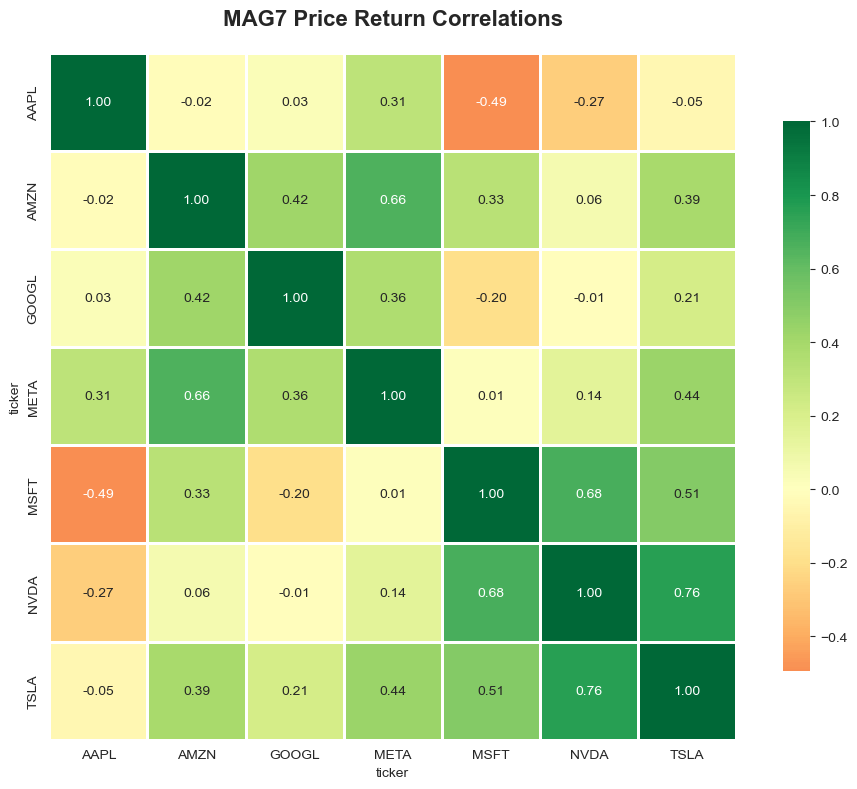


Average correlation across all ticker pairs: 0.203


In [8]:
# Cell 6: Price correlation matrix
# Pivot to wide format (tickers as columns, dates as rows)
returns_wide = price_obs.pivot(index='price_date', columns='ticker', values='daily_return')

# Calculate correlation
correlation_matrix = returns_wide.corr()

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('MAG7 Price Return Correlations', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print(f"\nAverage correlation across all ticker pairs: {correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)].mean():.3f}")

## Next Steps
**Explore patterns:**
   - How correlated are ticker movements?
   - Do tickers with similar sentiment move similarly?
   - When one ticker has strong sentiment, do others follow?
